# Task 03 - Keyword Spotting

## Steps to follow:
1. Analyze the data Preprocessing
2. Binarization Extract word images from full page
3. Compute some features
4. Preprocessing:
 1. Crop (bounding box, Polygon as clipping mask)
 2. Binarization (Otsu, Sauvola, Difference-of-Gaussian)
5. Dissimilarity Approaches (DTW)
 1. Feature extraction
 2. Similarity Analysis
6. Evaluation
 1. Recall-Precision Curve / Average Precision (AP)


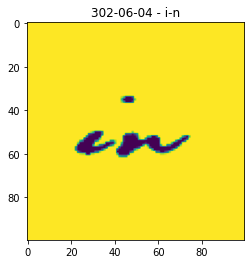

In [3]:
import random

import matplotlib.pyplot as plt
import numpy as np
from preprocessing import get_word_list

word_list = get_word_list()

sample_index = random.randint(0,len(word_list)-1)
sample = word_list[sample_index]

plt.title(f"{sample['id']} - {sample['transcription']}")
imgplot = plt.imshow(sample['word_img'])

In [4]:
%load_ext autoreload
%autoreload 2
from feature_extraction import features

def compute_features(words_list):
    features_vectors = []
    for i in range(len(words_list)):
        image = words_list[i]['word_img']
        features_vectors.append(features(image))
    return features_vectors

vectors = compute_features(word_list)
vectors[sample_index]

[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [2, 2, 57, 58, 1.0, 2],
 [2, 5, 55, 59, 1.0, 3],
 [2, 7, 54, 60, 1.0, 2],
 [2, 7, 54, 60, 1.0, 0],
 [2, 8, 53, 60, 1.0, 1],
 [2, 9, 52, 60, 1.0, 1],
 [2, 10, 51, 60, 1.0, 1],
 [2, 11, 50, 60, 1.0, 1],
 [2, 11, 50, 60, 1.0, 0],
 [4, 8, 50, 59, 0.8, 1],
 [4, 9, 50, 59, 0.9, 0],
 [4, 8, 50, 59, 0.8, 0],
 [4, 6, 50, 58, 0.6666666666666666, 1],
 [2, 4, 55, 58, 1.0, 5],
 [2, 3, 55, 57, 1.0, 1],
 [2, 2, 55, 56, 1.0, 1],
 [2, 3, 54, 56, 1.0, 1],
 [2, 3, 54, 56, 1.0, 0],
 [2, 2, 54, 55, 1.0, 1],
 [2, 4, 57, 60, 1.0, 2],
 [2, 5, 57, 61, 1.0,

In [47]:
from dynamic_time_warping import dtw_window
import time

def get_match_matrix(train, test):
    # used for a train/example set and a validation set
    similarity = np.zeros((6, len(train)))
    # k in range(6) because there are 5 different feature extractions
    start = time.time()
    for k in range(6):
        for i in range(len(train)):
            similarity[k][i] = dtw_window(test.T[k], train[i].T[k], 5)[-1, -1]
    print("-", int(time.time() - start), "s")
    return similarity


def get_match_list(set1):
    # input: match matrix
    # output: ranking [index of best, index of second best, ..., index of worst]
    sort_index = [np.argsort(set1[i]) for i in range(len(set1))]
    return sort_index


def get_sets(only_keywords):
    # get the sets and split them in train and validation set
    test_label, test_index, train_label, train_index, test_vector, train_vector = [], [], [], [], [], []
    file1 = open('task/keywords.txt', 'r')
    lines = file1.read().splitlines()
    keywords = []
    for i in lines:
        keywords.append(i)
    counter = 0
    for word in word_list:
        if "300" in word["id"] or "301" in word["id"] or "302" in word["id"] \
                or "303" in word["id"] or "304" in word["id"]:
            if word["transcription"] in keywords:
                test_index.append(counter)
                test_label.append(word["transcription"])
        else:
            if only_keywords:
                if word["transcription"] in keywords:
                    train_index.append(counter)
                    train_label.append(word["transcription"])
            else:
                train_index.append(counter)
                train_label.append(word["transcription"])
        counter += 1
    for i in range(len(vectors)):
        if i in test_index:
            test_vector.append(vectors[i])
        elif i in train_index:
            train_vector.append(vectors[i])
    print("size test set:", len(test_vector), "size train set:", len(train_vector))
    return test_vector, test_label, test_index, train_vector, train_label, train_index,


def main():
    # prepare sets
    test_vector_, test_label, test_index, train_vector_, train_label, train_index = get_sets(only_keywords=True)
    test_vector, train_vector = np.asarray(test_vector_), np.asarray(train_vector_)

    # dynamic time warping and ranking
    similarity_matrix = np.zeros((len(test_vector), 6, len(train_vector)))
    ranking_1 = []
    print("calculating dynamic time warping...")
    for i in range(len(test_vector)):
        print("predicted time left:", int((len(test_vector) - i) * len(train_vector) / 8), "s", end=' ')
        similarity_matrix[i] = get_match_matrix(train_vector, test_vector[i])
        ranking_1.append(get_match_list(similarity_matrix[i]))

    # sum up feature vectors and rank again
    ranking_2 = np.zeros((len(test_vector), len(train_vector)))
    for i in range(len(test_vector)):
        for k in range(6):
            for j in range(len(train_vector)):
                ranking_2[i, ranking_1[i][k][j]] += j
    ranking = get_match_list(ranking_2)

    # get hits, true or false
    match = np.zeros((len(test_vector), len(train_vector)))
    for i in range(len(test_vector)):
        for j in range(len(train_vector)):
            match[i][j] = 1 if train_label[ranking[i][j]] == test_label[i] else 0
    return match

matching = main()
print("total number of hits:", int(sum(sum(matching))))


size test set: 70 size train set: 325
calculating dynamic time warping...
predicted time left: 2843 s - 23 s
predicted time left: 2803 s - 23 s
predicted time left: 2762 s - 23 s
predicted time left: 2721 s - 23 s
predicted time left: 2681 s - 22 s
predicted time left: 2640 s - 22 s
predicted time left: 2600 s - 24 s
predicted time left: 2559 s - 24 s
predicted time left: 2518 s - 26 s
predicted time left: 2478 s - 23 s
predicted time left: 2437 s - 24 s
predicted time left: 2396 s - 25 s
predicted time left: 2356 s - 24 s
predicted time left: 2315 s - 25 s
predicted time left: 2275 s - 24 s
predicted time left: 2234 s - 25 s
predicted time left: 2193 s - 25 s
predicted time left: 2153 s - 24 s
predicted time left: 2112 s - 20 s
predicted time left: 2071 s - 20 s
predicted time left: 2031 s - 20 s
predicted time left: 1990 s - 20 s
predicted time left: 1950 s - 20 s
predicted time left: 1909 s - 20 s
predicted time left: 1868 s - 20 s
predicted time left: 1828 s - 20 s
predicted time l

Average Precision: 0.17282027387080712


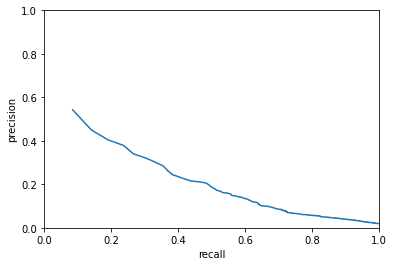

In [49]:
def calculate_threshold(match):
    # calculate recall & precision for each threshold

    n = len(match[0])
    recalls, precisions = [], []
    ap = 0
    for i in range(1, n):
        tp,fp,fn = 0,0,0
        for word in range(len(match)):
            tp += sum(match[word][:i])
            fp += (i - sum(match[word][:i]))
            fn += sum(match[word]) - sum(match[word][:i])
            
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        recalls.append(recall)
        precisions.append(precision)
        if i!=1:
            ap += (recalls[i-1]-recalls[i-2])*precisions[i-1]

    print("Average Precision:", ap)
    # plot precision and recall
    plt.plot(recalls, precisions)
    plt.ylabel("precision")
    plt.xlabel("recall")
    plt.ylim([0,1])
    plt.xlim([0,1])
    plt.show()

calculate_threshold(matching)